In [1]:
import numpy as np
import cPickle
import cv2
import glob
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

from utils.template_match_target import *

In [2]:
def get_im_cv2(path, img_width, img_height):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    #resized = cv2.resize(img, (img_width, img_height))#, cv2.INTER_LINEAR)
    return img

def load_data(path, data_type, img_width, img_height):
    X, X_id, y = [], [], []
    minpix = 2                                  #minimum number of pixels for crater to count
    files = glob.glob('%s*.png'%path)
    minpix, maxpix = 2, 100                          #minimum pixels required for a crater to register in an image
    print "number of %s files are: %d"%(data_type,len(files))
    for f in files:
        flbase = os.path.basename(f)
        img = get_im_cv2(f,img_width,img_height) / 255.
        X.append(img)
        y.append(np.array(Image.open('%smask.tiff'%f.split('.png')[0])))
        X_id.append(int(flbase.split('lola_')[1].split('.png')[0]))
        
        #csv = pd.read_csv('%s.csv'%f.split('.png')[0])
        #csv = csv[(csv['Diameter (pix)'] < maxpix) & (csv['Diameter (pix)'] > minpix)]
        #target = mdm.make_mask(csv, img, binary=True, truncate=True, rings=True)
        #target = mdm.make_circlering_mask(csv, img, binary=True, truncate=True)
        #target = mdm.make_mask(csv, img, binary=True, rings=True, ringwidth=1, truncate=True)
        #y.append(target)
    return  X, y, X_id

def read_and_normalize_data(path, img_width, img_height, data_flag):
    if data_flag == 0:
        data_type = 'train'
    elif data_flag == 1:
        data_type = 'test'
    data, target, id_ = load_data(path, data_type, img_width, img_height)
    data = np.array(data).astype('float32')     #convert to numpy, convert to float
    data = data.reshape(len(data),img_width,img_height,1)
    target = np.array(target).astype('float32')
    print('%s shape:'%data_type, data.shape)
    return data, target, id_

#save target no border for Hough circles
def save_image(data, cm, fn):
    sizes = np.shape(data)
    height = float(sizes[0])
    width = float(sizes[1])
    fig = plt.figure()
    fig.set_size_inches(width/height, 1, forward=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(data, cmap=cm)
    plt.savefig(fn, dpi = height) 
    
def rescale_and_invcolor(data, inv_color, rescale):
    for img in data:
        if inv_color == 1:
            img[img > 0.] = 1. - img[img > 0.]
        if rescale == 1:
            minn, maxx = np.min(img[img>0]), np.max(img[img>0])
            low, hi = 0.1, 1                                                #low, hi rescaling values
            img[img>0] = low + (img[img>0] - minn)*(hi - low)/(maxx - minn) #linear re-scaling
    return data

In [3]:
dim, inv_color, rescale = 256, 1, 1
train_data, train_target, train_id = read_and_normalize_data('datasets/rings/Train_rings/', dim, dim, 0)
test_data, test_target, test_id = read_and_normalize_data('datasets/rings/Test_rings/', dim, dim, 1)

#invcolor and rescale
if inv_color==1 or rescale==1:
    train_data = rescale_and_invcolor(train_data, inv_color, rescale)
    test_data = rescale_and_invcolor(test_data, inv_color, rescale)

number of train files are: 20
('train shape:', (20, 256, 256, 1))
number of test files are: 40
('test shape:', (40, 256, 256, 1))


In [24]:
from keras.models import load_model

Using TensorFlow backend.


In [25]:
filename = 'models/unet_s256_rings_predfull_FL5_glorot_normal.h5'
model = load_model(filename)

In [26]:
n,off=2,0
target = model.predict(test_data[off:(n+off)].astype('float32'))
target_ids = test_id[off:(n+off)]

In [4]:
#convert pixel radius to absolute
P = cPickle.load(open('datasets/rings/lolaout_test.p', 'r'))

master_img_height_pix = 20000.0  #number of pixels for height
master_img_height_lat = 180.0
R_moon = 1737.0                  #radius of the moon (km)
olen = 256.0                     #output length (pixels)

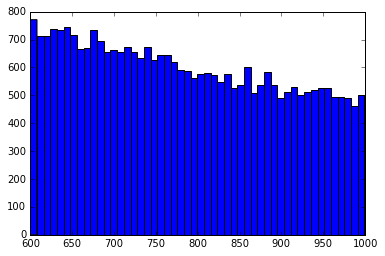

In [23]:
#distribution of pix_to_km values.
arr = []
for i in range(len(P)):
    P_ = P[i]
    arr.append(P_['box'][2] - P_['box'][0])
    
plt.hist(arr,50);
#P[0]['llbd']

# there's a problem here where the radii are all exactly the same!! Bug somewhere

In [27]:
#code for checking that a discovered crater is new, and hasn't been already discovered in another image.
match_thresh2 = 50.
dim = 256.
pred_crater_dist = np.empty([0,3])
for i in range(1):
    coords = template_match_target(target[i])  #this is returning tons of duplicates still for some reason... that might be the ultimate issue
    P_ = P[test_id[i]]
    #mask = np.zeros((dim,dim))
    img_pix_height = P_['box'][2] - P_['box'][0]
    pix_to_km = (master_img_height_lat/master_img_height_pix)*(np.pi/180.0)*(img_pix_height/olen)*R_moon
    long_pix,lat_pix,radii_pix = coords.T
    radii_km = radii_pix*pix_to_km
    long_deg = P_['llbd'][0] + (P_['llbd'][1]-P_['llbd'][0])*(long_pix/dim)
    lat_deg = P_['llbd'][3] - (P_['llbd'][3]-P_['llbd'][2])*(lat_pix/dim)
    
    tuple_ = np.column_stack((long_deg,lat_deg,radii_km))
    print tuple_  #there's a problem here where the radii are all exactly the same!! Bug somewhere
    #only add unique (non-duplicate) values to the master pred_crater_dist
    for j in range(len(tuple_)):
        print pred_crater_dist
        diff = (pred_crater_dist - tuple_[j])**2
        diffsum = np.asarray([sum(x) for x in diff])
        index = diffsum < match_thresh2
        if len(np.where(index==True)[0]) == 0: #unique value
            print pred_crater_dist, tuple_[j]
            pred_crater_dist = np.append(pred_crater_dist,tuple_[j])
#             if len(np.where(index==True)[0]) > 0: #duplicate
#                 print tuple_[j], pred_crater_dist[index]
#                 tuple_ = np.delete(tuple_,j,axis=0)
#                 N = len(tuple_)
#             else: 
#                 j += 1
                #maybe just add the isolated crater of interest to pred_crater_dist here instead 
    
plt.hist(pred_crater_dist, 10);
plt.title('radius distribution of labelled craters')
plt.xlabel('crater radius (km)')

[[ 158.93066406  -18.65393066    2.63787938]
 [ 161.80084229  -18.85534668    3.51717251]
 [ 161.59942627  -21.17163086    2.63787938]
 [ 158.72924805  -21.59963989    2.63787938]
 [ 163.94088745  -21.62481689    3.51717251]
 [ 163.86535645  -16.71530151    4.39646564]
 [ 163.91571045  -19.33370972    4.39646564]
 [ 162.70721436  -19.33370972    4.39646564]
 [ 163.56323242  -19.56030273    4.39646564]
 [ 162.93380737  -19.68618774    4.39646564]
 [ 158.67889404  -22.73260498    3.51717251]
 [ 162.27920532  -18.04968262    4.39646564]
 [ 160.29022217  -18.80499268    4.39646564]
 [ 162.93380737  -19.30853271    4.39646564]
 [ 163.63876343  -19.35888672    5.27575876]
 [ 161.27212524  -18.83016968    5.27575876]
 [ 160.01327515  -19.68618774    5.27575876]
 [ 158.88031006  -22.22906494    5.27575876]
 [ 163.86535645  -19.63583374    6.15505189]
 [ 160.39093018  -20.11419678    7.91363815]
 [ 161.37283325  -20.01348877   11.43081066]
 [ 160.23986816  -22.90884399   10.55151753]
 [ 159.534

TypeError: 'numpy.float64' object is not iterable

In [37]:
tuple_, coords

(array([[ 158.93066406,  -18.65393066,    2.63787938],
        [ 161.80084229,  -18.85534668,    3.51717251],
        [ 161.59942627,  -21.17163086,    2.63787938],
        [ 158.72924805,  -21.59963989,    2.63787938],
        [ 163.94088745,  -21.62481689,    3.51717251],
        [ 163.86535645,  -16.71530151,    4.39646564],
        [ 163.91571045,  -19.33370972,    4.39646564],
        [ 162.70721436,  -19.33370972,    4.39646564],
        [ 163.56323242,  -19.56030273,    4.39646564],
        [ 162.93380737,  -19.68618774,    4.39646564],
        [ 158.67889404,  -22.73260498,    3.51717251],
        [ 162.27920532,  -18.04968262,    4.39646564],
        [ 160.29022217,  -18.80499268,    4.39646564],
        [ 162.93380737,  -19.30853271,    4.39646564],
        [ 163.63876343,  -19.35888672,    5.27575876],
        [ 161.27212524,  -18.83016968,    5.27575876],
        [ 160.01327515,  -19.68618774,    5.27575876],
        [ 158.88031006,  -22.22906494,    5.27575876],
        [ 

In [11]:
pred_crater_dist[i]

IndexError: index 0 is out of bounds for axis 0 with size 0

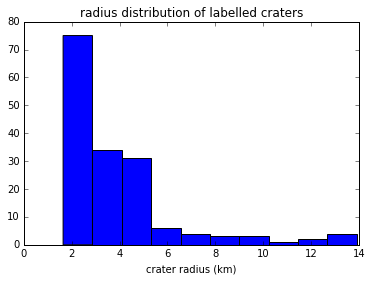

In [71]:
plt.hist(master_radii_dist, 10)
plt.title('radius distribution of labelled craters')
plt.xlabel('crater radius (km)')